# Exploratory Data Analysis (EDA) of the Movies Dataset

This Jupyter Notebook focuses on **Exploratory Data Analysis (EDA)** of the **movies** dataset. It encompasses generating visualizations, exploring different aspects of the dataset, and documenting findings. 

The primary aim of this project is to uncover and explain insights into the characteristics, trends, and patterns present in the **movies** dataset in detail. A comprehensive report on the findings in this Jupyter Notebook can be found in the **Movies_EDA_Doc.pdf** document. You can access the report on my GitHub portfolio in the same folder where this notebook is located.


In [1]:
# Import standard libraries
import ast  # For safely evaluating strings containing Python expressions
import json  # For parsing and manipulating JSON data
from datetime import datetime  # For manipulating dates and times

# Import third-party libraries
import numpy as np  # Library for numerical computations and working with arrays
import pandas as pd  # Data analysis library providing data structures and functions for working with structured data
import fuzzywuzzy  # Library for fuzzy string matching
from fuzzywuzzy import process  # Specific functionality for processing fuzzy matches
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations
import seaborn as sns  # Statistical data visualization library based on matplotlib

# Enable inline plotting for Jupyter notebooks
%matplotlib inline


## Load the Movies Dataset
Let's load the movies dataset and take a look at the initial data.


In [3]:
# Load the movies dataset
movies_df = pd.read_csv('movies.csv')

## Clean the Data

### 1. Identify Redundant or Unnecessary Columns
To enhance the clarity and relevance of the dataset, it is essential to identify and remove any redundant or unnecessary columns. Making decisions based on concise and relevant data facilitates more effective analysis. Therefore, we will eliminate the following columns from the dataset: `['homepage', 'keywords', 'original_language', 'original_title', 'overview', 'production_companies', 'status', 'tagline']`, as they do not contribute to the objectives of this analysis.

#### 2. Remove Rows with Missing Data
In the dataset, some movies have a budget or revenue recorded as zero, indicating that this information is either missing or has not been provided. To maintain the integrity of our analysis, it is crucial to discard these entries from the dataframe. By removing these rows, we ensure that our dataset reflects only complete and reliable records for further analysis.

#### 3. Change Data Types
To facilitate easier manipulation of the dataset, it is essential to use the appropriate Python data types. Specifically, we will convert the release date column to `DateTime` format and extract the year from this date. This transformation will enable more effective analysis of trends and patterns over the years, allowing us to gain insights into yearly data.

In [4]:
# Remove unnecessary columns
movies_df.drop(['homepage', 'keywords', 'original_language', 'original_title', 'overview', 
                 'production_companies', 'status', 'tagline'], axis=1, inplace=True)

# Remove duplicate rows
movies_df.drop_duplicates(inplace=True)

# Remove rows with revenue = 0
movies_df.drop(movies_df[movies_df['revenue'] == 0].index, inplace=True)

# Remove rows with missing data
movies_df.drop(movies_df[movies_df['budget'] == 0].index, inplace=True)

# Change data types
# Change the release_date column to DateTime
movies_df['date_parsed'] = pd.to_datetime(movies_df['release_date'], format='%Y-%m-%d')

# Extract the release year from every release date
movies_df['Year'] = movies_df['date_parsed'].dt.strftime('%Y')

# Change Year datatype to integer
movies_df['Year'] = movies_df['Year'].str.strip().astype(np.int16)

# Change revenue and budget datatypes
movies_df['revenue'] = movies_df['revenue'].astype(np.int64)
movies_df['budget'] = movies_df['budget'].astype(np.int64)


## Parse JSON Columns
On examining the dataset, we notice that the columns `genres`, `production_countries`, and `spoken_languages` are stored in JSON format. This structure can complicate data manipulation within the dataframe. To address this issue, we will use the `parse_col_json` function to flatten these columns into a more accessible format, making it easier to interpret and analyze the data effectively. We will convert JSON format columns to a list of strings for easier analysis.


In [5]:
# Convert from JSON format to a list of strings
def parse_col_json(column, key):
    """
    Args:
        column: string
            name of the column to be processed.
        key: string
            name of the dictionary key which needs to be extracted
    """
    for index, i in zip(movies_df.index, movies_df[column].apply(json.loads)):
        list1 = []
        for j in range(len(i)):
            list1.append((i[j][key]))  # the key 'name' contains the name of the genre
        movies_df.loc[index, column] = str(list1)

# Flatten data in columns
parse_col_json('genres', 'name')
parse_col_json('production_countries', 'name')
parse_col_json('spoken_languages', 'name')

# Inspect flattened data
movies_df.sample(1)


,budget,genres,id,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,date_parsed,Year
1962,25000000,"['Action', 'Drama', 'Western']",174751,15.333575,['United States of America'],2016-01-01,1397284,98.0,['English'],Jane Got a Gun,5.4,285,2016-01-01,2016


## Data Exploration
In this section, we will explore the dataset to identify trends and key insights regarding budgets, profits, and popular movies.


<ipython-input-6-758640575198>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expensive_cheapest, y='title', x='budget', palette='bright')


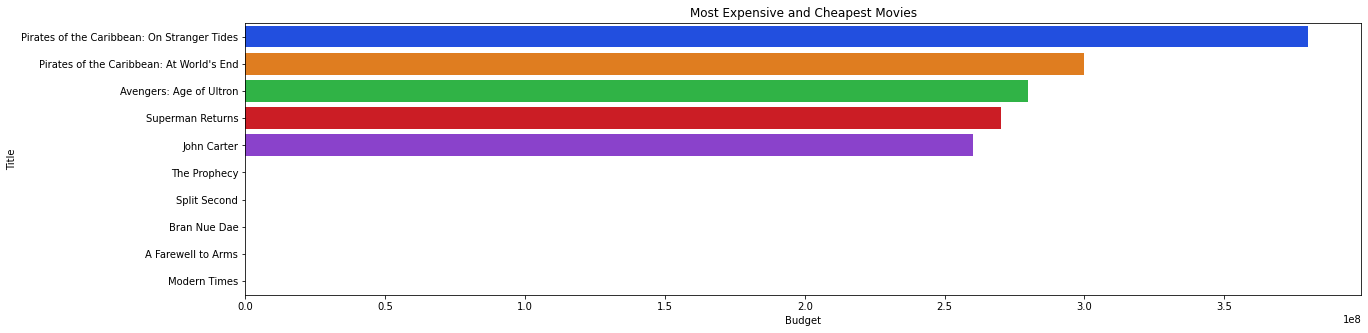

In [6]:
# Create a dataframe with all the movies in the "Action" genre
action_movies = movies_df[movies_df['genres'].str.contains('Action')]

# Get most expensive movies by sorting according to budget (descending order)
most_expensive = movies_df.sort_values(by='budget', ascending=False)

# Get cheapest movies by sorting according to budget (ascending order)
cheapest = movies_df.sort_values(by='budget', ascending=True)

# Create a new dataframe with the top five most expensive and top five cheapest movies.
frames = [most_expensive.iloc[0:5, :], cheapest.iloc[0:5, :]]

# Concatenate the dataframes
expensive_cheapest = pd.concat(frames)

# Sort the movies in descending order by budgets
expensive_cheapest.sort_values(by='budget', ascending=False, inplace=True)

# Bar plot
plt.figure(figsize=(20, 5))
sns.barplot(data=expensive_cheapest, y='title', x='budget', palette='bright')
plt.xlabel('Budget')
plt.ylabel('Title')
plt.title("Most Expensive and Cheapest Movies")
plt.show()


### Top 5 Most Profitable Movies
Now, let's identify the most and least profitable movies in the dataset.


<ipython-input-7-ede0513a787f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=movies_profit, y='title', x='profit', palette='pastel')


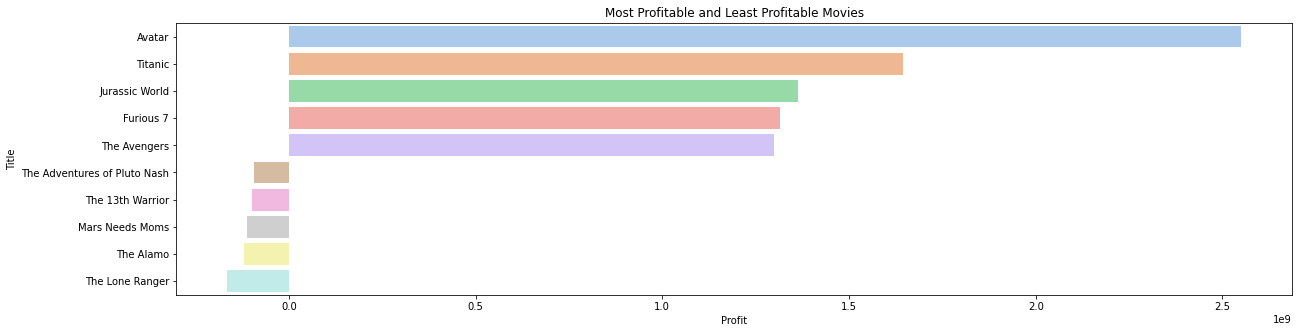

In [7]:
# Calculate the profit column and add it to the movies dataframe
profit = movies_df.revenue - movies_df.budget
movies_df['profit'] = profit

# Create most and least profitable temp dataframes
most_profitable = movies_df.sort_values(by='profit', ascending=False)
least_profitable = movies_df.sort_values(by='profit', ascending=True)

# Create a new dataframe with the top five most and least profitable movies.
frames = [most_profitable.iloc[0:5, :], least_profitable.iloc[0:5, :]]

# Concatenate the dataframes
movies_profit = pd.concat(frames)

# Sort the movies in descending order by profit
movies_profit.sort_values(by='profit', ascending=False, inplace=True)

# Bar plot
plt.figure(figsize=(20, 5))
sns.barplot(data=movies_profit, y='title', x='profit', palette='pastel')
plt.xlabel('Profit')
plt.title("Most Profitable and Least Profitable Movies")
plt.ylabel('Title')
plt.show()


### Most Popular Movies
Next, we will find and visualize the most popular movies based on their popularity ratings.


<ipython-input-8-772ea4198a32>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ten_pop, y='title', x='popularity', palette='dark')


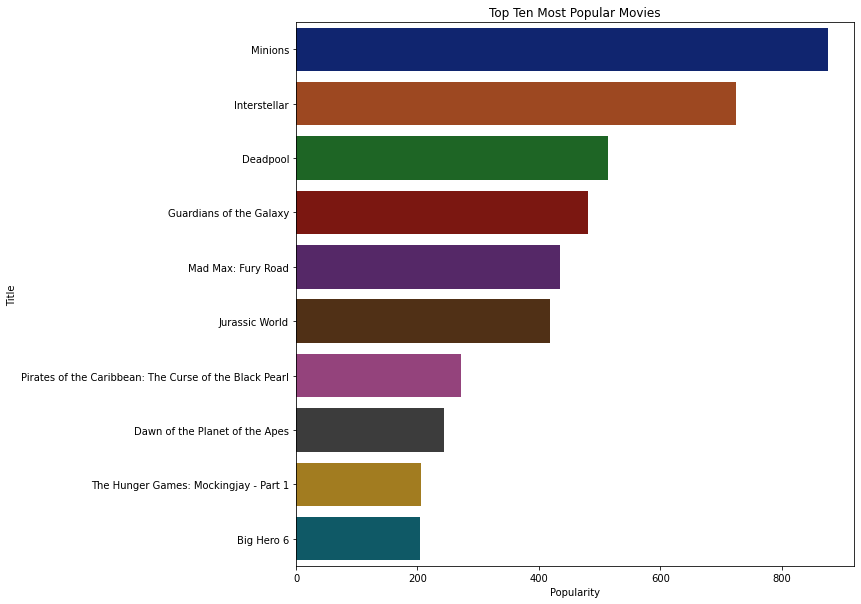

In [8]:
# Sort new temp dataframe by popularity 
movies_pop = movies_df.sort_values(by='popularity', ascending=False)

# Top 10 most popular movies
top_ten_pop = movies_pop[['title', 'popularity']].head(10)

# Bar plot
plt.figure(figsize=(10, 10))
sns.barplot(data=top_ten_pop, y='title', x='popularity', palette='dark')
plt.xlabel('Popularity')
plt.ylabel('Title')
plt.title('Top Ten Most Popular Movies')
plt.show()


### Movies Rated Above 7
Let's identify and visualize the movies that have a rating above 7.


<ipython-input-9-d9fbf9f580ae>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fifteen, y='title', x='vote_average', palette='deep')


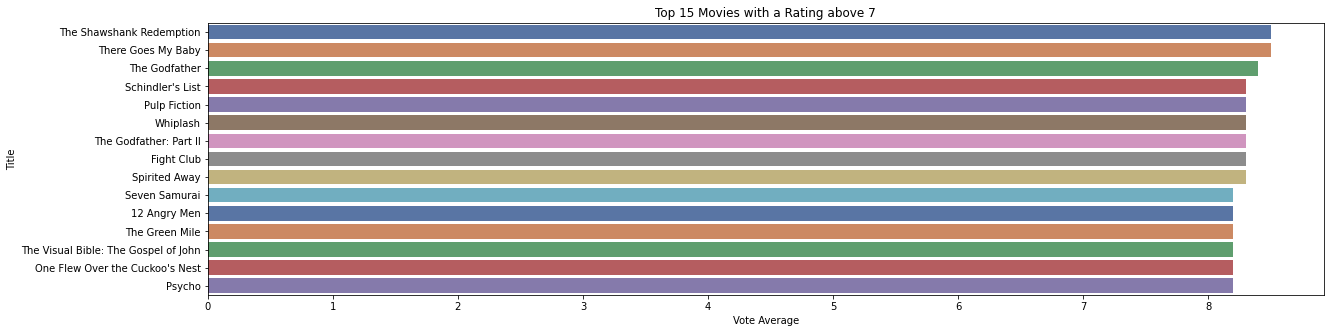

In [9]:
# Create new temp dataframe for movies with vote_average above 7 
above_seven_rating = movies_df[movies_df.vote_average > 7].sort_values(by='vote_average', ascending=False)

# Top 15 movies with a rating above 7
top_fifteen = above_seven_rating[['title', 'vote_average']].head(15)

# Bar plot
plt.figure(figsize=(20, 5))
sns.barplot(data=top_fifteen, y='title', x='vote_average', palette='deep')
plt.xlabel('Vote Average')
plt.title("Top 15 Movies with a Rating above 7")
plt.ylabel('Title')
plt.show()


### Most Successful Genres
We will analyze the genres to identify the most successful ones based on revenue generation.


In [10]:
# Expand the data frame to have additional entries for movies with multiple genres
movies_genre = movies_df.assign(genres=movies_df['genres'].str.split(','))
movies_genre = movies_genre.explode('genres')

# Get the unique genres in the dataframe
genres = movies_genre['genres'].unique()
print(f"Unique genres in the dataframe:\n\n{genres}")

# Function to replace close matches in the genres column
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    # Get a list of unique strings (data frame column entries)
    strings = df[column].unique()
    
    # Get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # Get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # Get rows of all close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # Replace all rows with close matches with the input 'string_to_match'
    df.loc[rows_with_matches, column] = string_to_match
    
    # Let us know when the function is done
    print("Replacement complete!")

# Use replace_matches_in_column function for each unique genre string
genre_strings = [
    "Action", "Science Fiction", "Thriller", "Western", "War",
    "Mystery", "Adventure", "Family", "Fantasy", "Documentary",
    "Foreign", "History", "Romance", "Music", "Crime", "Animation",
    "Comedy", "Drama", "Horror"
]

for genre in genre_strings:
    replace_matches_in_column(df=movies_genre, column='genres', string_to_match=genre)

# Replace '[]' genre in genre's column with 'Unknown'
movies_genre.replace('[]', 'Unknown', inplace=True)

# Confirm the unique genres in the dataframe
genres = movies_genre['genres'].unique()
print(f"\nConfirmed unique genres in the dataframe after replacement:\n\n{genres}")


Unique genres in the dataframe:

["['Action'" " 'Adventure'" " 'Fantasy'" " 'Science Fiction']"
 "['Adventure'" " 'Action']" " 'Crime']" " 'Crime'" " 'Drama'"
 " 'Thriller']" "['Fantasy'" " 'Action'" " 'Adventure']" "['Animation'"
 " 'Family']" " 'Fantasy']" " 'Thriller'" " 'Western']" " 'Family'"
 "['Science Fiction'" " 'Comedy'" "['Drama'" " 'Romance'" "['Thriller'"
 " 'Science Fiction'" "['Family'" " 'Comedy']" "['Action']" " 'Horror'"
 " 'Romance']" " 'Animation'" " 'Drama']" "['Science Fiction']"
 "['Comedy'" " 'Mystery'" "['Fantasy']" "['History'" " 'War']" "['War'"
 " 'History'" " 'Mystery']" " 'Animation']" "['Adventure']" "['Comedy']"
 " 'War'" " 'History']" "['Western'" " 'Western'" "['Drama']" " 'Horror']"
 "['Romance'" " 'Music']" "['Crime'" "['Animation']" "['War']"
 "['Mystery'" "['Horror'" " 'Music'" "['Thriller']" "['Music'"
 "['Western']" "['Horror']" "['Music']" "['Romance']" "['Documentary']"
 " 'Documentary'" "['History']" " 'Documentary']" "['Documentary'"
 " 'Fore

### Visualizations of Genres
Next, we will visualize the frequency of movies by genre and their total revenue.


<ipython-input-11-e6eb93e081e5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_count, x='genres', y='Count', palette='coolwarm')


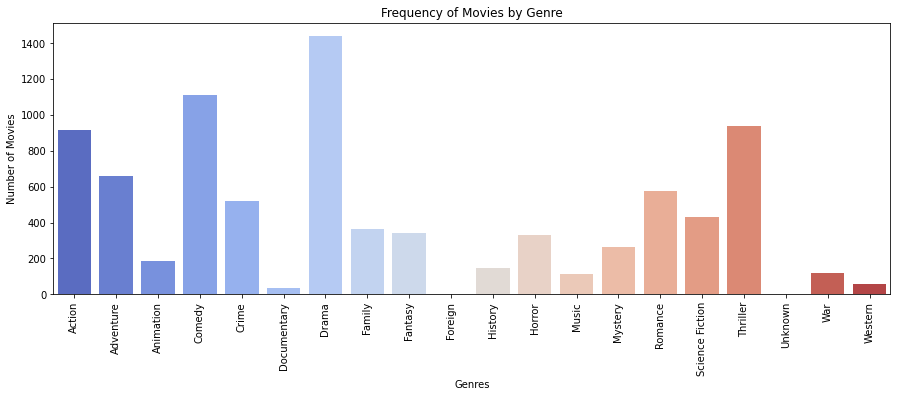

<ipython-input-11-e6eb93e081e5>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_revenue, x='genres', y='revenue', palette='rocket')


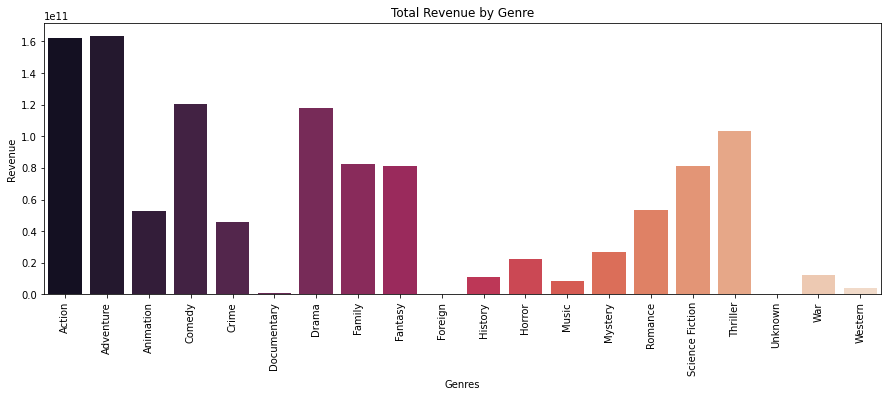

In [11]:
# Count the total number of movies in each genre
genre_count = movies_genre.groupby('genres').count()['title'].reset_index(name='Count')

# Create a bar plot for the frequency of movies by genre
plt.figure(figsize=(15, 5))
sns.barplot(data=genre_count, x='genres', y='Count', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Frequency of Movies by Genre")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.show()

# Group by genres and sum the revenue
genre_revenue = movies_genre.groupby('genres')['revenue'].sum().reset_index()

# Create a bar plot for the total revenue by genre
plt.figure(figsize=(15, 5))
sns.barplot(data=genre_revenue, x='genres', y='revenue', palette='rocket')
plt.xticks(rotation=90)
plt.title("Total Revenue by Genre")
plt.xlabel("Genres")
plt.ylabel("Revenue")
plt.show()


# Conclusion
In this analysis, we explored the 'movies' dataset, performed data cleaning and parsing of JSON columns, and identified trends in budgets, profits, and genres. We discovered the most and least expensive movies, analyzed their profitability, and identified the most popular movies. Finally, we visualized the performance of genres based on movie count and revenue.

This analysis provides valuable insights into the movie industry and can serve as a foundation for more in-depth studies.
